# Persistence Images

This notebook demonstrates basic usage of the PerImage class.

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate a persistence diagram with Ripser 

In [29]:
from itertools import product

import numpy as np
from sklearn import datasets
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt

from ripser import Rips
from persimmon import PersImage

## Generate persistence diagram using Ripser

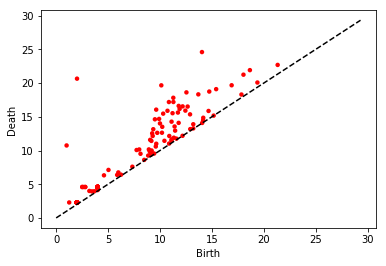

In [30]:
# lots of random noise and 2 circles
data = np.concatenate([150 * np.random.random((300,2)), 
                       10 + 10 * datasets.make_circles(n_samples=100)[0],
                       100 + 20 * datasets.make_circles(n_samples=100)[0]])

rips = Rips()
dgm = rips.fit_transform(data)
diagram = dgm[1]
rips.plot(diagram)

## Convert diagram to persistence image 

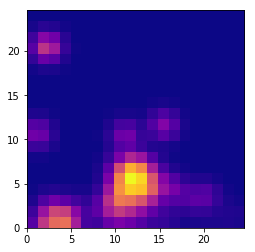

In [31]:
pim = PersImage(spread=1)
img = pim.transform(diagram)
pim.show(img, diagram)